# Gather unWISE photometry for the HST sample

The goal of this notebook is to document how we retrieve DR14 SDSS *ugriz* and unWISE *W1-W4* (forced) photometry for the HST HizEA sample of galaxies.

The input catalog is
* $HIZEA_DIR/etc/hst_sample.dat

and the output (row-matched) catalog containing *just* the SDSS/unWISE photometry is
* $HIZEA_DIR/etc/XXX

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import fitsio
from astropy.io import ascii
from astropy.table import Table

In [36]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [37]:
%matplotlib inline

In [20]:
def read_hizea():
    cat = ascii.read( os.path.join( os.getenv('HIZEA_DIR'), 'etc', 'hst_sample.dat' ) )
    return cat

In [21]:
hizea = read_hizea()
hizea

galaxy,ra,dec,z,r_e,vout,wise_sfr
str10,float64,float64,float64,float64,int64,int64
J1506+5402,226.65123962,54.03909907,0.608,0.13,-1211,621
J0905+5759,136.3483394,57.98680093,0.712,0.1,-2470,344
J1341-0321,205.40333219,-3.35701866,0.658,0.16,-875,490
J0944+0930,146.07436936,9.50537816,0.514,0.15,-1778,161
J2140+1209,325.00205248,12.15405848,0.752,0.23,-606,378
J0826+4305,126.66007153,43.09150738,0.603,0.31,-1228,246
J1613+2834,243.38552761,28.5707732,0.449,0.68,-2416,461
J1219+0336,184.98241233,3.60441687,0.451,0.76,-1830,253
J1107+0417,166.7619674,4.28410187,0.467,0.56,-1828,118


In [27]:
def read_unwise():
    unwisefile = os.path.join(os.getenv('IM_DATA_DIR'), 'unwise', 'specmatch-dr10.fits')
    ff = fitsio.FITS(unwisefile)
    columns = list( ('wise_ra', 'wise_dec') )
    columns = columns + ['wise_{}_nanomaggies'.format(band) for band in ('w1', 'w2', 'w3', 'w4')]
    columns = columns + ['wise_{}_nanomaggies_ivar'.format(band) for band in ('w1', 'w2', 'w3', 'w4')]
    print('Reading {}'.format(unwisefile))
    ww = ff[1].where("wise_ra > 0 && wise_dec > 0")
    unwise = Table(ff[1].read(columns=columns, ext=1, rows=ww))
    return unwise

In [28]:
unwise = read_unwise()
unwise

Reading /Users/ioannis/research/data/unwise/specmatch-dr10.fits


wise_ra,wise_dec,wise_w1_nanomaggies,wise_w1_nanomaggies_ivar,wise_w2_nanomaggies,wise_w2_nanomaggies_ivar,wise_w3_nanomaggies,wise_w3_nanomaggies_ivar,wise_w4_nanomaggies,wise_w4_nanomaggies_ivar
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
146.943881222,0.0391758351521,1363.25,0.00500747,1358.72,0.000374917,-839.871,9.20983e-08,174809.0,1.39546e-10
147.329501905,0.0289007540392,11432.1,0.0013918,13918.1,0.00011565,496630.0,3.14952e-08,8.2514e+06,6.14016e-11
146.763835489,0.0414016530208,469.098,0.00414787,1412.71,0.000306162,24892.5,6.6069e-08,60771.7,9.65525e-11
146.760769038,0.0159539188264,4319.5,0.00201472,5020.11,0.00015421,108112.0,3.84801e-08,480762.0,6.80027e-11
146.809135997,0.0263629083752,7506.41,0.00155128,8952.06,0.000122387,14974.5,3.01488e-08,641314.0,5.72089e-11
146.729008857,0.0269572735449,3413.85,0.00309281,3694.31,0.000239629,1511.0,5.21995e-08,58216.6,8.79149e-11
146.630700168,0.0709745384969,2902.07,0.00206002,3358.64,0.000161601,3242.64,3.9688e-08,152124.0,7.36789e-11
146.608070514,0.0476782446485,1341.39,0.00250974,1631.97,0.000191587,38923.7,4.87348e-08,144250.0,8.31926e-11
146.369872098,0.0821892399741,2359.74,0.0022775,2520.18,0.000180823,63687.5,3.84821e-08,177877.0,6.80085e-11


In [57]:
unwisecoord = SkyCoord(ra=unwise['wise_ra']*u.deg, dec=unwise['wise_dec']*u.deg)
hizeacoord = SkyCoord(ra=hizea['ra']*u.deg, dec=hizea['dec']*u.deg)
idx, sep2d, d3d = hizeacoord.match_to_catalog_sky(unwisecoord, nthneighbor=1)

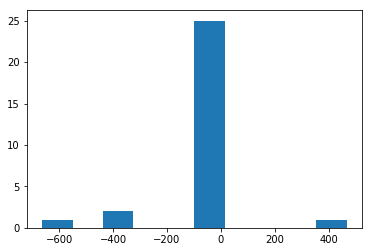

In [67]:
_ = plt.hist(3600*(unwise['wise_ra'][idx] - hizea['ra']).data)

In [54]:
def qa_sep(sep2d):
    fig, ax = plt.subplots()
    _, _, _ = ax.hist(sep2d.arcsec, bins=100, range=(0, 0.5), alpha=0.5)
    ax.set_xlabel('Separation (arcsec)')
    ax.set_ylabel('Number of Galaxies')

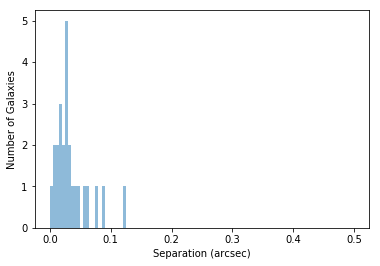

In [55]:
qa_sep(sep2d)

In [44]:
rad = 0.5 * u.arcsec

In [45]:
indx_unwise, indx_hizea, d2d, _ = hizeacoord.search_around_sky(unwisecoord, rad)
nmatch = len(indx_unwise)
print('Found {}/{} objects with matching unWISE photometry within {}'.format(nmatch, len(unwise), rad))

Found 29/2683302 objects with matching unWISE photometry within 0.5 arcsec


In [48]:
indx_hizea

array([ 1,  1,  1,  7,  9,  8,  8, 20, 23, 14,  4, 19,  5,  5,  0, 27, 25,
       28, 13, 15, 12, 22,  3, 18,  6, 24, 17, 21, 26])

In [49]:
d2d

<Angle [  1.35684889e-05,  1.35684889e-05,  1.35684889e-05,
          6.98878376e-06,  1.66074419e-05,  3.67445625e-06,
          3.67445625e-06,  6.35715581e-06,  4.89926602e-06,
          2.36320667e-06,  9.45719974e-06,  1.67166476e-05,
          1.21665550e-05,  1.21665550e-05,  5.05999119e-06,
          2.21041218e-05,  8.65478024e-06,  4.91883204e-07,
          8.10351452e-06,  1.72612732e-06,  7.93524669e-06,
          6.54428191e-06,  7.40767537e-06,  2.43246545e-05,
          2.98349841e-06,  1.00988391e-05,  3.34814153e-05,
          7.11556168e-06,  4.73862206e-06] deg>

In [46]:
unwise[indx_unwise]

wise_ra,wise_dec,wise_w1_nanomaggies,wise_w1_nanomaggies_ivar,wise_w2_nanomaggies,wise_w2_nanomaggies_ivar,wise_w3_nanomaggies,wise_w3_nanomaggies_ivar,wise_w4_nanomaggies,wise_w4_nanomaggies_ivar
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
136.348322046,57.9867909564,473.654,0.0071384,567.186,0.000569416,19708.2,1.10561e-07,287461.0,1.53568e-10
136.348322046,57.9867909564,473.654,0.0071384,567.186,0.000569416,19708.2,1.10561e-07,287461.0,1.53568e-10
136.348322046,57.9867909564,473.654,0.0071384,567.186,0.000569416,19708.2,1.10561e-07,287461.0,1.53568e-10
184.982405382,3.60441774002,979.807,0.00480286,1336.84,0.000270522,55407.0,5.80838e-08,752576.0,1.12701e-10
135.389259613,3.23679973794,799.928,0.00387882,989.332,0.000291457,21333.8,6.14208e-08,326297.0,8.95338e-11
166.761968507,4.28409836516,582.781,0.00433966,1069.95,0.000315964,49007.1,7.5229e-08,499158.0,1.13078e-10
166.761968507,4.28409836516,582.781,0.00433966,1069.95,0.000315964,49007.1,7.5229e-08,499158.0,1.13078e-10
226.515381611,61.53003093,519.875,0.0136851,614.166,0.00107465,13966.1,2.91995e-07,40246.0,3.95725e-10
248.69367172,46.3296813523,1526.03,0.0119278,2301.25,0.000916749,19253.2,3.93181e-07,-90411.8,2.63432e-10


### [1] Read the sample and write out a temporary file we can upload to CasJobs.

In [2]:
def write_casjobs_file():
    outfile = os.path.join(os.sep, 'Users', 'ioannis', 'Desktop', 'hizea_sample.tmp')
    dat = ascii.read( os.path.join( os.getenv('HIZEA_DIR'), 'etc', 'hst_sample.dat' ) )
    out = Table()
    out['hizea_id'] = np.arange(len(dat))
    out['hizea_ra'] = dat['ra']
    out['hizea_dec'] = dat['dec']
    print('Writing {}'.format(outfile))
    out.write(outfile, format='ascii.commented_header', overwrite=True)
    return out

In [3]:
out = write_casjobs_file()
out

Writing /Users/ioannis/Desktop/hizea_sample.tmp


hizea_id,hizea_ra,hizea_dec
int64,float64,float64
0,226.65123962,54.03909907
1,136.3483394,57.98680093
2,205.40333219,-3.35701866
3,146.07436936,9.50537816
4,325.00205248,12.15405848
5,126.66007153,43.09150738
6,243.38552761,28.5707732
7,184.98241233,3.60441687
8,166.7619674,4.28410187


### [2] Import the sample into CasJobs.

Unfortunately when you import a simple ASCII file, CasJobs does not keep the RA,Dec coordinates in double precision.  So first create a table in the *Query* tab (using the *Quick* submission option) thusly:
```SQL
CREATE TABLE hizea ( hizea_id int, hizea_ra float, hizea_dec float );
```
and then in the *Import* tab be sure to import the data directly into this table.

### [3] Search for ObjID using RA,Dec positions.

Next, gather the SDSS ObjID using the RA,Dec positions and a 1 arcsec search radius.  In the *Query* tab be sure to set the *Context* to DR14 and then execute the following query.

```SQL
SELECT
  h.hizea_id,
  h.hizea_ra,
  h.hizea_dec,
  p.objid,
  p.ra,
  p.dec,
  p.run,
  p.rerun,
  p.camcol
INTO mydb.hizea_match FROM mydb.hizea AS h
  OUTER APPLY dbo.fGetNearestObjEq( h.hizea_ra, h.hizea_dec, 0.01666) AS n 
  LEFT JOIN dr14.PhotoObj AS p ON n.objid=p.objid
ORDER BY h.hizea_id
```

### [4] Finally gather the SDSS + unWISE photometry.

Finally, we use the output of the previous step to retrieve the full set of SDSS (*ugriz*) and unWISE (*W1W2*) forced photometry by executing the following query (again, using the DR14 *Context*).  Note that we call the output table (not creatively) *hst_sample_sdssWISEphot.fits*.

```SQL
SELECT
  h.hizea_id,
  p.objid,
  p.ra,
  p.dec,
  p.run,
  p.rerun,
  p.camcol,
  p.field,
  p.type,
  p.petroflux_u,
  p.petroflux_g,
  p.petroflux_r,
  p.petroflux_i,
  p.petroflux_z,
  p.petrofluxivar_u,
  p.petrofluxivar_g,
  p.petrofluxivar_r,
  p.petrofluxivar_i,
  p.petrofluxivar_z,
  p.modelflux_u,
  p.modelflux_g,
  p.modelflux_r,
  p.modelflux_i,
  p.modelflux_z,
  p.modelfluxivar_u,
  p.modelfluxivar_g,
  p.modelfluxivar_r,
  p.modelfluxivar_i,
  p.modelfluxivar_z,
  p.cmodelflux_u,
  p.cmodelflux_g,
  p.cmodelflux_r,
  p.cmodelflux_i,
  p.cmodelflux_z,
  p.cmodelfluxivar_u,
  p.cmodelfluxivar_g,
  p.cmodelfluxivar_r,
  p.cmodelfluxivar_i,
  p.cmodelfluxivar_z,
  p.extinction_u,
  p.extinction_g,
  p.extinction_r,
  p.extinction_i,
  p.extinction_z,
  p.petroR50_u,
  p.petroR50_g,
  p.petroR50_r,
  p.petroR50_i,
  p.petroR50_z,
  f.w1_nanomaggies,
  f.w1_nanomaggies_ivar,
  f.w2_nanomaggies,
  f.w2_nanomaggies_ivar
INTO mydb.hst_sample_sdssWISEphot from mydb.hizea_match as h
  JOIN dr14.PhotoObj AS p ON h.objid=p.objid
  JOIN dr14.wiseForcedTarget AS f ON h.objid=f.objid
ORDER BY h.hizea_id
```